## ПЛАН РАБОТЫ

1. ознакомление с данными и подготовка
2. анализ временного ряда
3. обучение модели <br>
    3.1. GradientBoostingRegressor <br>
    3.2. RandomForestRegressor <br>
    3.3. DecisionTreeRegressor <br>
    3.4. LGBM <br>
4. тесирование
5. вывод


In [2]:
!pip install -q lightgbm
!pip install -q catboost
!pip install -q xgboost

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure
import seaborn as sns
sns.set_style("ticks", {"axes.grid": True})
plt.rcParams["figure.figsize"] = (16, 5)

from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb

RANDOM_STATE = 42
# убираем предупреждения Pandas Future warning 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
def lineplot(data, title):
    data.plot(color="green")
    plt.title(title)
    plt.show()

In [5]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## Ознакомление с данными и подготовка

In [6]:
try:
    taxi = pd.read_csv('D:\docs\DS\\taxis.csv')
except:
    taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')
    
taxi.info()
taxi.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [7]:
# проверим, всё ли ок с хронологическим порядком:
taxi.index.is_monotonic_increasing

True

In [8]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'])
taxi = taxi.set_index('datetime')

In [9]:
taxi = taxi.resample('1h').sum()
taxi.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [10]:
print(f"Размер датасета: {taxi.shape}")

Размер датасета: (4416, 1)


**промежуточный вывод**:

* ✅ выполнено ознакомление: данные датасета чистые без пропусков.
* ✅ выполнено ресемплирование по одному часу: т.к. по ТЗ необходимо предсказывать количество заказов такси на следующий час, заказы просуммированы.

## Анализ временного ряда
сперва посмотрим на общий график временного ряда и оценим количество заказов.

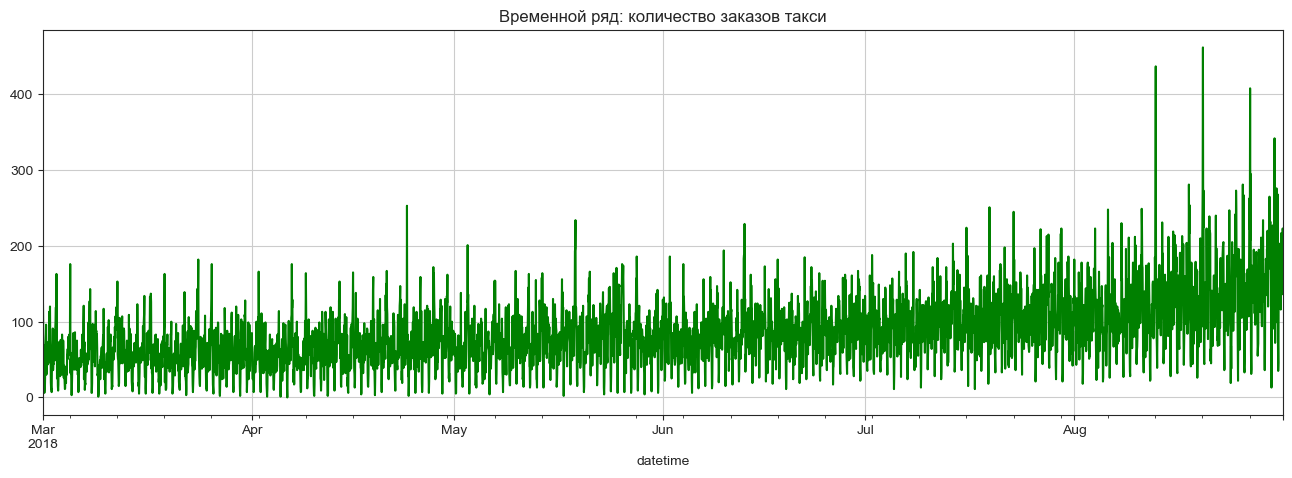

Количество наблюдений: 4416 
Период:  2018-03-01 00:00:00 — 2018-08-31 23:00:00 
Количество заказов в час:
Среднее: 84.42278079710145 
Медиана: 78.0 
Мин:     0 
Макс:    462


In [11]:
lineplot(taxi['num_orders'], "Временной ряд: количество заказов такси")

# описательная статистика
print(f"Количество наблюдений: {taxi['num_orders'].shape[0]} \n"
      f"Период:  {taxi.index.min()} — {taxi.index.max()} \n"
      f"Количество заказов в час:\n"
      f"Среднее: {taxi['num_orders'].mean()} \n"
      f"Медиана: {taxi['num_orders'].median()} \n"
      f"Мин:     {taxi['num_orders'].min()} \n"
      f"Макс:    {taxi['num_orders'].max()}"
     )

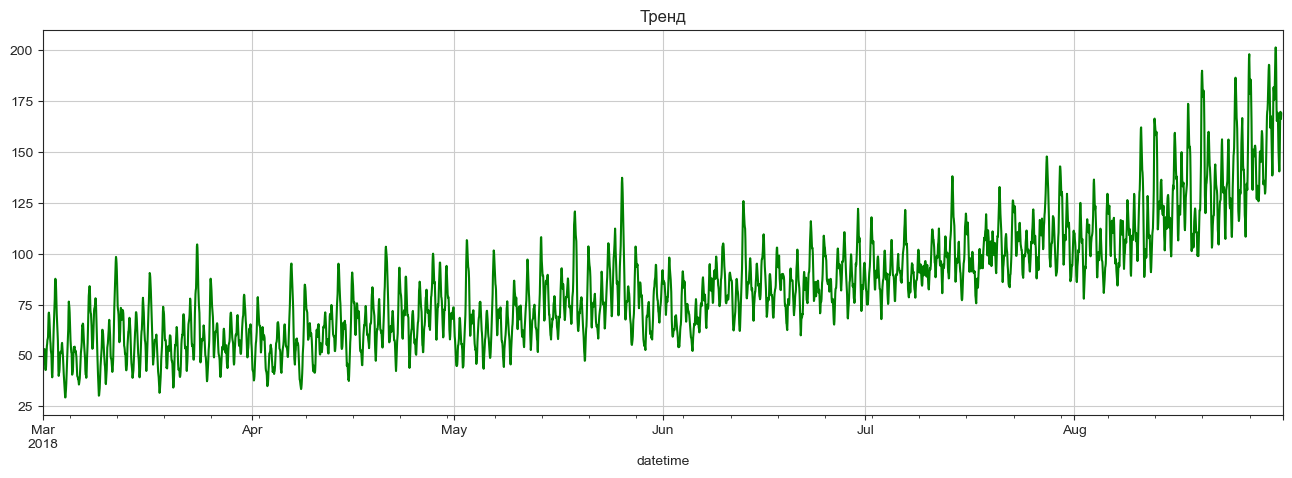

In [12]:
decomposed = seasonal_decompose(taxi, model='additive', period=12)
lineplot(decomposed.trend, 'Тренд')

* тред растет к летним периодам: пора отпусков, возможно, увеличение количества туристов в городе.
* плавно увеличивается скорость треда

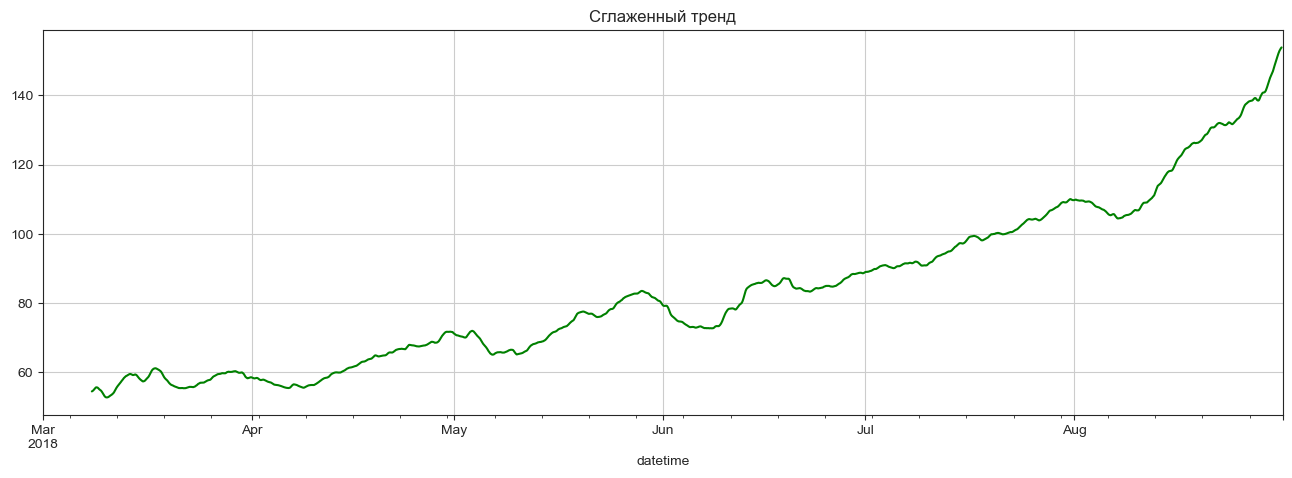

In [14]:
lineplot(decomposed.trend.shift().rolling(24*7).mean(), 'Сглаженный тренд')

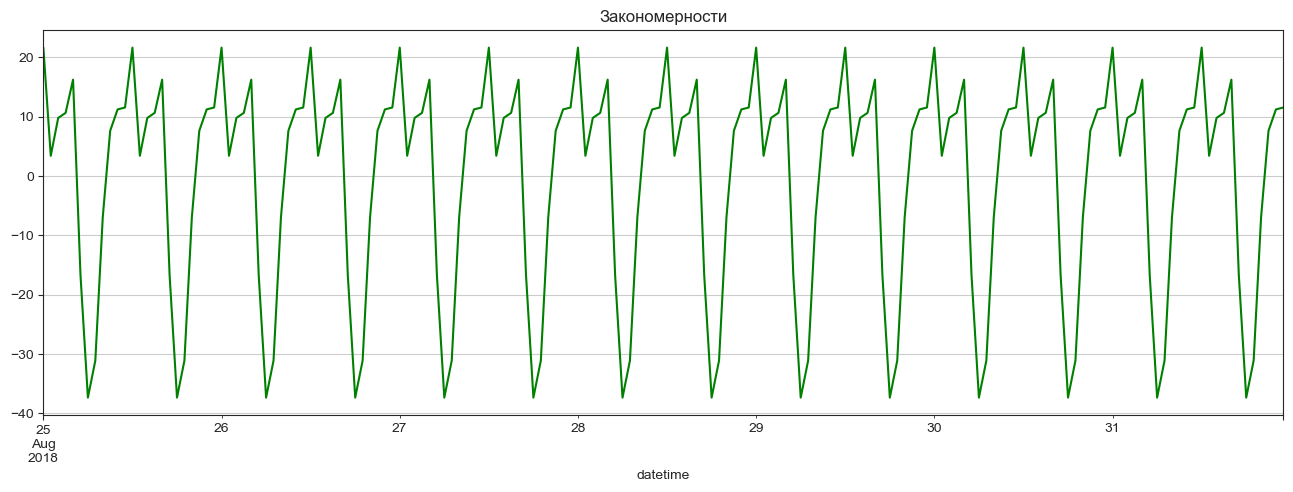

In [15]:
lineplot(decomposed.seasonal.tail(24*7), 'Закономерности')

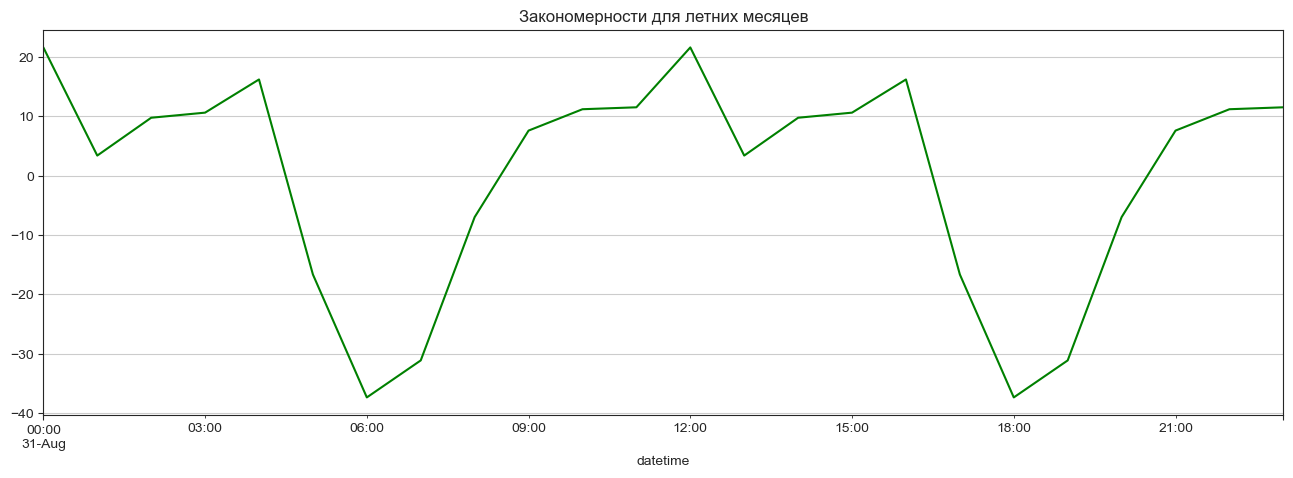

In [16]:
taxi_summer = decomposed.seasonal.loc[decomposed.seasonal.index.month.isin([6, 7, 8])]
taxi_summer_weekly = taxi_summer.tail(24)
lineplot(taxi_summer_weekly, 'Закономерности для летних месяцев')

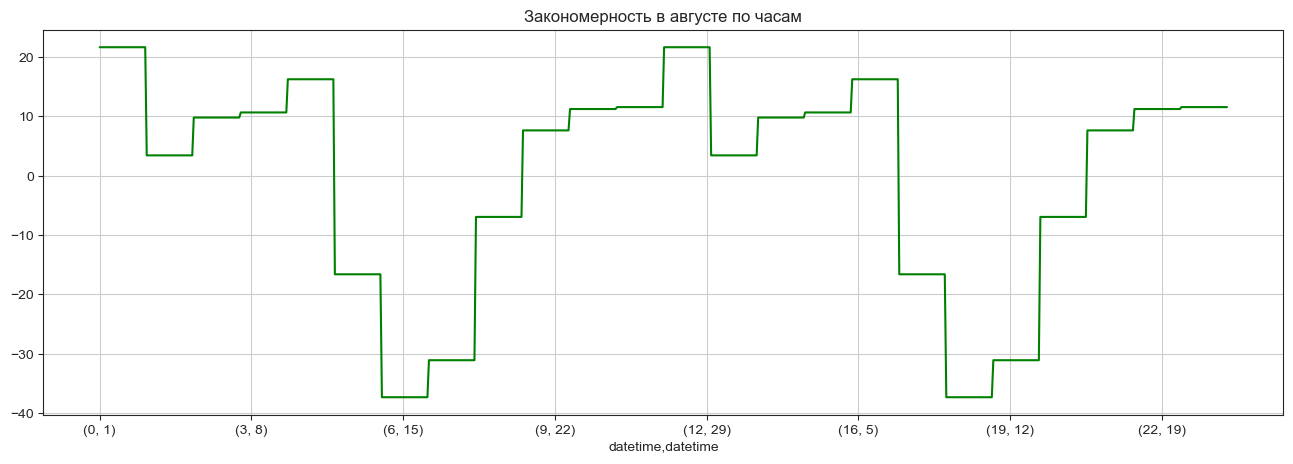

In [17]:
taxi_aug = decomposed.seasonal.loc[(decomposed.seasonal.index.month == 8)]
taxi_aug_hourly = taxi_aug.groupby([taxi_aug.index.hour, taxi_aug.index.day]).mean()
lineplot(taxi_aug_hourly, 'Закономерность в августе по часам')

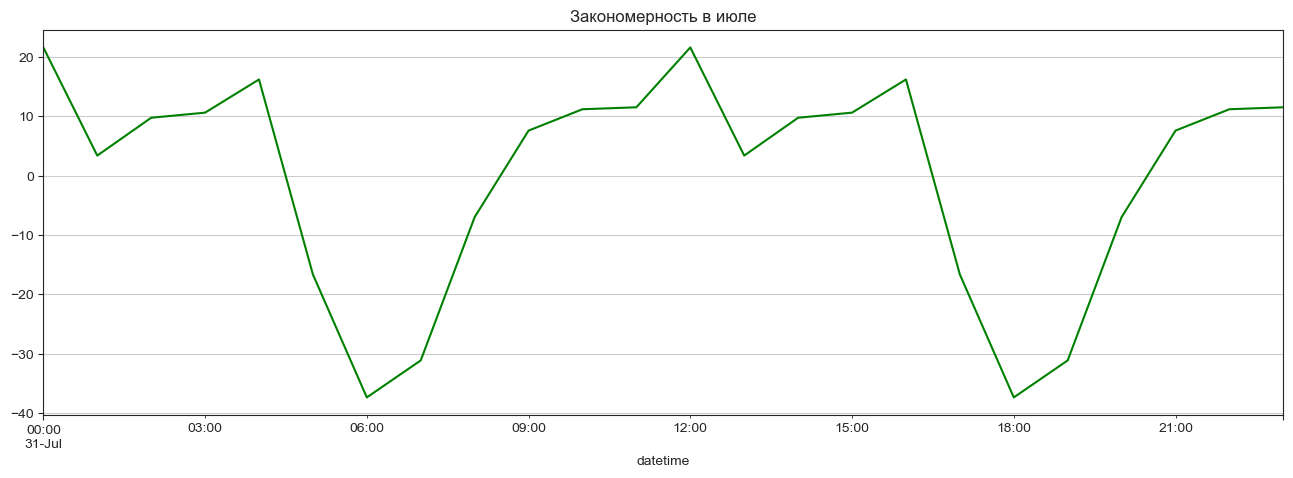

In [19]:
lineplot(decomposed.seasonal.loc[(decomposed.seasonal.index.month == 7)].tail(24), 'Закономерность в июле')

**промежуточный вывод**: <br>
* паттерн повторяется каждые 30 дней
* наблюдается рост в начале месяца + характерные всплески в конце месяца
* спад спроса ночью, рост в дневное время <br>

исследуем шумы:

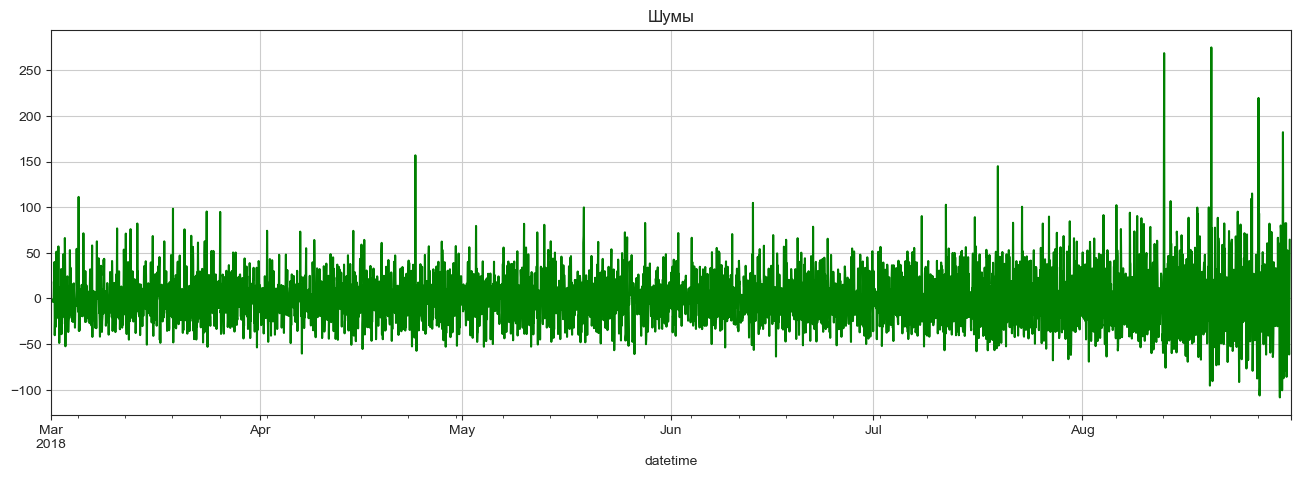

In [20]:
lineplot(decomposed.resid.shift(), 'Шумы')

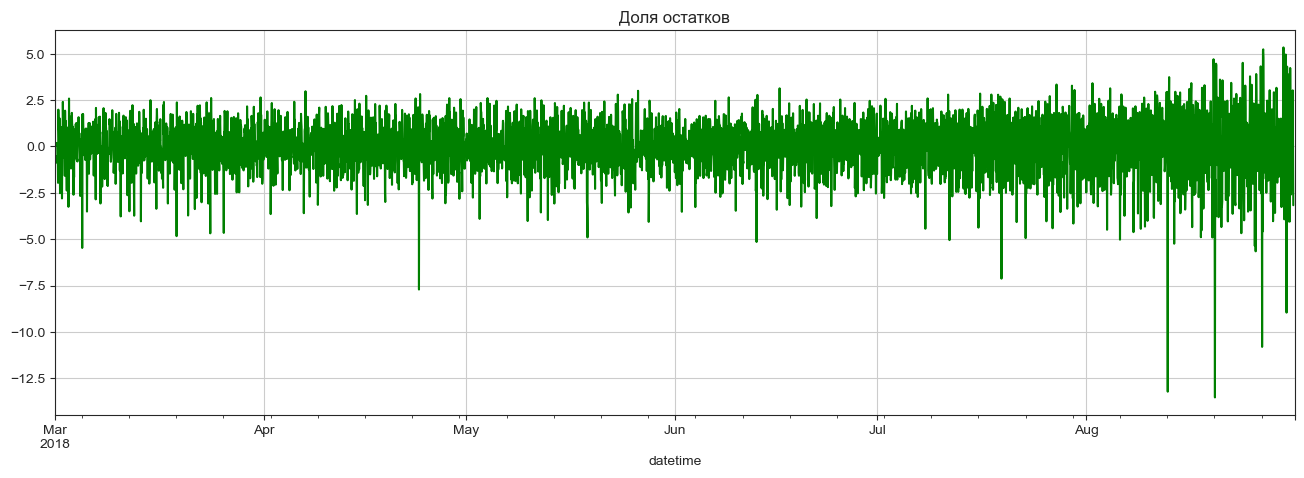

In [21]:
lineplot(decomposed.resid / decomposed.resid.sum(), 'Доля остатков')

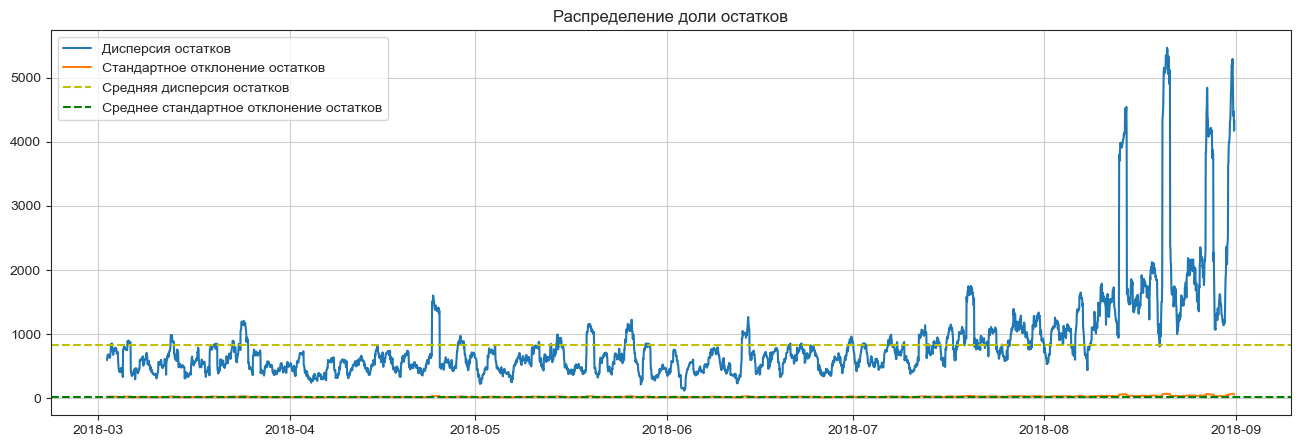

In [22]:
resid_var = decomposed.resid.var()
resid_std = decomposed.resid.std()

# plt.figure(figsize=(12, 6))
plt.plot(decomposed.resid.rolling(window=30).var(), label='Дисперсия остатков')
plt.plot(decomposed.resid.rolling(window=30).std(), label='Стандартное отклонение остатков')
plt.axhline(y=resid_var, color='y', linestyle='--', label='Средняя дисперсия остатков')
plt.axhline(y=resid_std, color='g', linestyle='--', label='Среднее стандартное отклонение остатков')
plt.legend()
plt.title('Распределение доли остатков')
plt.show()

проверка на стационарность

In [23]:
ts = taxi['num_orders']
st_test = adfuller(ts, regression='ctt')

if st_test[1] < 0.05:
    print('значение с индексом 1 меньше p-value, наш ряд стационарный')
else:
    print('значение с индексом 1 больше p-value, ряд нестационарный')

значение с индексом 1 меньше p-value, наш ряд стационарный


**промежуточный вывод**:<br>
* стремительный рост спроса; пиковый месяц на данный момент - август
* остаток декомпозиции имеет постоянное среднее значение, однако заметны ощутимые всплески (необходима дополнительная информация от заказчика: возможно, связано с маркетинговыми активностями в определённые дни)

## Обучение модели

In [24]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)

In [25]:
print("Среднее количество заказов в час:", test['num_orders'].mean())

Среднее количество заказов в час: 139.55656108597285


проверим модель на адекватность двуми способами:
* первый: прогнозом константой.
* второй: предыдущее значение ряда.

In [27]:
pred_median = np.ones(len(test)) *  train['num_orders'].median()
print('RMSE:', mean_squared_error(test['num_orders'], pred_median) ** 0.5)

RMSE: 87.15277582981295


In [28]:
pred_previous = test['num_orders'].shift()
pred_previous.iloc[0] = train['num_orders'].iloc[-1]

print('RMSE:',  mean_squared_error(test['num_orders'], pred_previous)**0.5)

RMSE: 58.856486242815066


второй способ оптимальнее.

напишем функцию для создания обучающих признаков (month, day, dayofweek и признаки для скользящего среднего rolling_mean и lag_i для признаков отстающего значения)

In [29]:
def make_features(data, max_lag, rolling_mean_size):
    data = data.copy()
    # data['month'] = data.index.month
    # data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [30]:
def plot_acf_pacf(series, lags=50):
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plot_acf(series, lags=lags, ax=plt.gca())
    plt.title("ACF: Автокорреляционная функция")
    
    plt.subplot(1, 2, 2)
    plot_pacf(series, lags=lags, ax=plt.gca(), method='ywm')
    plt.title("PACF: Частичная автокорреляция")
    
    plt.tight_layout()
    plt.show()

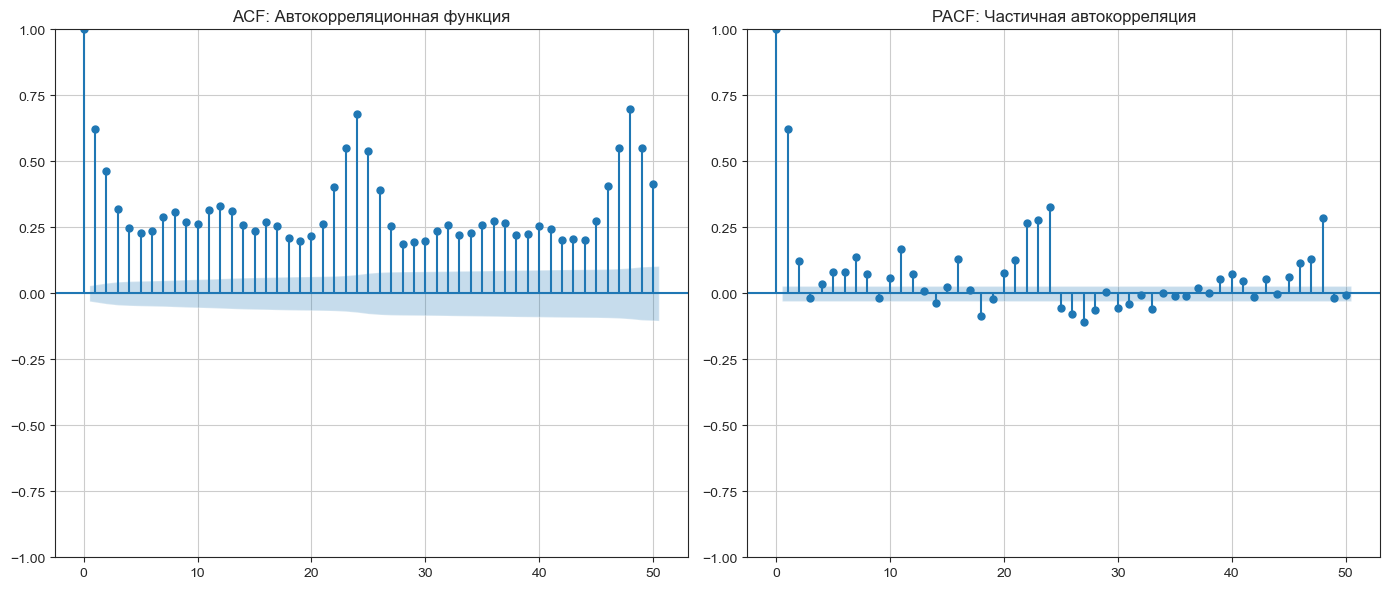

In [31]:
plot_acf_pacf(taxi['num_orders'], lags=50)

на что обращаем внимание:
* пики на лагах 1-5 = ближайшие несколько часов связаны между собой
* пики около 24 лага = можно говорить о суточной закономерности

по результатам ACF/PACF можно сказать, что:
* корректно выбран признак  `hour` для учёта времени суток.
* корректно выбран `dayofweek`: отображает недельный паттерн
* для параметра `max_lag` возьмём значение 48
* для параметра `rolling_mean_size` возьмём значение 24

In [32]:
taxi_2 = make_features(taxi, 48, 24)

In [33]:
X = taxi_2.drop('num_orders', axis=1)
y = taxi_2['num_orders']

In [34]:
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    # Индексация DataFrame X и Series y по индексам train_index и test_index
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Шаг 1: Удаляем пустые значения из X_train
    X_train_cleaned = X_train.dropna()

    # Шаг 2: Фильтруем y_train, оставляя только те индексы (даты), которые есть в X_train_cleaned
    y_train_filtered = y_train[y_train.index.isin(X_train_cleaned.index)]

    # Шаг 3: Проверяем размеры X_train и y_train
    print(f"\nРазмер X_train: {X_train_cleaned.shape[0]}, размер y_train: {y_train_filtered.shape[0]}")

    # При необходимости: фильтрация X_train_cleaned для соответствия y_train_filtered
    X_filtered = X_train_cleaned[X_train_cleaned.index.isin(y_train_filtered.index)]

    # Шаг 4: Печатаем отфильтрованные данные
    print("\nОтфильтрованный X_train:")
    print(X_filtered)
    print("\nОтфильтрованный y_train:")
    print(y_train_filtered)


Размер X_train: 688, размер y_train: 688

Отфильтрованный X_train:
                     hour  dayofweek  lag_1  lag_2  lag_3  lag_4  lag_5  \
datetime                                                                  
2018-03-03 00:00:00     0          5   72.0  119.0  101.0   93.0   49.0   
2018-03-03 01:00:00     1          5  163.0   72.0  119.0  101.0   93.0   
2018-03-03 02:00:00     2          5  108.0  163.0   72.0  119.0  101.0   
2018-03-03 03:00:00     3          5   25.0  108.0  163.0   72.0  119.0   
2018-03-03 04:00:00     4          5   64.0   25.0  108.0  163.0   72.0   
...                   ...        ...    ...    ...    ...    ...    ...   
2018-03-31 11:00:00    11          5   48.0   65.0   56.0   20.0    7.0   
2018-03-31 12:00:00    12          5   99.0   48.0   65.0   56.0   20.0   
2018-03-31 13:00:00    13          5   24.0   99.0   48.0   65.0   56.0   
2018-03-31 14:00:00    14          5   80.0   24.0   99.0   48.0   65.0   
2018-03-31 15:00:00    15       

In [35]:
print(X_filtered.shape)
y_train_filtered.shape

(3632, 51)


(3632,)

In [36]:
train_models = []

### GradientBoostingRegressor

In [37]:
GBR = GradientBoostingRegressor()


parameters = {'learning_rate': [0.02, 0.03],
              'subsample'    : [0.5, 0.6],
              'n_estimators' : [100,200],
              'max_depth'    : [5,6]
             }

In [38]:
tscv = TimeSeriesSplit(n_splits=5)
grid_GBR = GridSearchCV(estimator=GBR,
                        param_grid=parameters, 
                        cv=tscv,
                        scoring="neg_mean_squared_error",
                        n_jobs=-1)

grid_GBR.fit(X_filtered, y_train_filtered)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.02, 0.03], 'max_depth': [5, 6],
                         'n_estimators': [100, 200], 'subsample': [0.5, 0.6]},
             scoring='neg_mean_squared_error')

In [39]:
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)


 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.02, max_depth=6, n_estimators=200,
                          subsample=0.6)

 The best parameters across ALL searched params:
 {'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.6}


In [40]:
pred = grid_GBR.predict(X_filtered)

rmse_train = rmse(y_train_filtered, pred)
print("RMSE:", rmse_train)

RMSE: 13.74370950241548


In [41]:
train_models.append([GBR, rmse_train])

### RandomForestRegressor

In [42]:
forest = RandomForestRegressor(random_state=RANDOM_STATE)

In [43]:
parameters = {'n_estimators':range(50,100,10), 
              'max_depth':range(1,11,2)}

tscv = TimeSeriesSplit(n_splits=2)

In [44]:
r_search = GridSearchCV(estimator=forest, cv=tscv, param_grid=parameters)

In [45]:
r_search.fit(X_filtered, y_train_filtered)
r_search.best_params_

{'max_depth': 9, 'n_estimators': 70}

In [46]:
predictions = r_search.predict(X_filtered)
rmse_train = rmse(y_train_filtered, predictions)
print("RMSE:", rmse_train)

RMSE: 14.127926426117662


In [47]:
train_models.append([forest, rmse_train])

### DecisionTreeRegressor

In [48]:
tree = DecisionTreeRegressor(random_state=RANDOM_STATE)
parameters = {'max_depth':range(1,11,2)}

tscv = TimeSeriesSplit(n_splits=2)
gsearch = GridSearchCV(estimator=tree, cv=tscv, param_grid=parameters)
gsearch.fit(X_filtered, y_train_filtered)
gsearch.best_params_

{'max_depth': 3}

In [49]:
predictions = gsearch.predict(X_filtered)
rmse_train = rmse(y_train_filtered, predictions)
print("RMSE:", rmse_train)

RMSE: 25.498243917831555


In [50]:
train_models.append([tree, rmse_train])

### LGBM

In [54]:
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

lgbm = lgb.LGBMRegressor(verbose=-1)

param_grid = {
    'num_leaves': [40, 51],
    'max_depth': [1, 10],
    'learning_rate': [0.01, 0.1]
}

tscv = TimeSeriesSplit(n_splits=2)

grid_search_lgbm = GridSearchCV(estimator=lgbm, 
                                param_grid=param_grid,
                                scoring="neg_mean_squared_error", 
                                cv=tscv,
                                verbose=0)

grid_search_lgbm.fit(X_filtered, y_train_filtered)

print("Лучшие параметры:", grid_search_lgbm.best_params_)

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 40}


In [55]:
predictions = grid_search_lgbm.predict(X_filtered)
rmse_train = rmse(y_train_filtered, predictions)
print("RMSE:", rmse_train)

RMSE: 8.734387264494822


In [56]:
train_models.append([lgbm, rmse_train])

In [57]:
compare = pd.DataFrame(train_models, columns=['model', 'rmse_train'])
compare.sort_values(by='rmse_train')

,model,rmse_train
3,LGBMRegressor(verbose=-1),8.734387
0,GradientBoostingRegressor(),13.743710
1,RandomForestRegressor(random_state=42),14.127926
2,DecisionTreeRegressor(random_state=42),25.498244


rmse всех моделей в пределах максимального по ТЗ (48)

## Тестирование
наилучшие результаты показала модель LGBM, посмотрим, как хорошо она проявит себя на тесте:

In [58]:
y_pred = grid_search_lgbm.predict(X_test)
rmse_test = rmse(y_test, y_pred)
print("RMSE:", rmse_test)

RMSE: 39.24469658827058


результаты теста положительные: укладываемся в ограничение, обозначенное в ТЗ (rmse < 48) </br>
для наглядности построим график истинных/предсказанных значений:

In [60]:
def pl(grid, title, rmse):
    preds = pd.Series(grid.predict(X_test), index = y_test.index, name='preds')
    df_preds = pd.concat([y_test, preds], axis=1)

    plt.title(title + ' (RMSE=' + str(rmse) + ')')
    data = df_preds['2018-08-20':]
    sns.lineplot(x=data.index, y=data['num_orders'], label='Истинные значения')
    sns.lineplot(x=data.index, y=data['preds'], label='Предсказания')

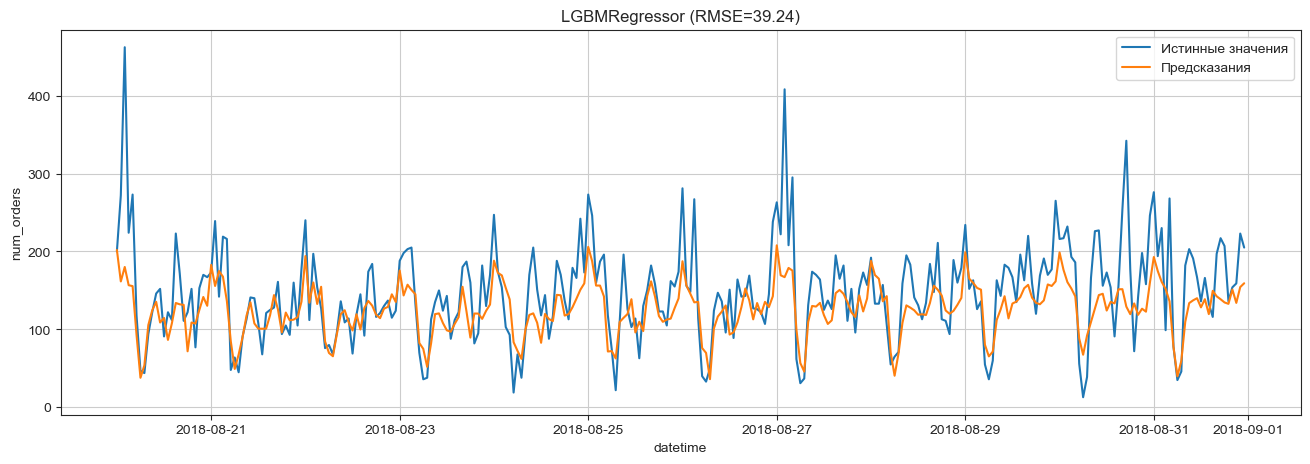

In [61]:
pl(grid_search_lgbm, 'LGBMRegressor', round(rmse_test, 2))

## Вывод

в рамках выполнения задачи заказчика мы:
1. проверили исходный датасет, убедились в отсутствии попусков
2. провели ресемплирование данных, просуммировав заказы за каждый час
3. выявили и отобразили на графике восходящий тренд: увеличение заказов в летний период, вероятно, связанное с отпусками и туристическим сезоном
4. с помощью графиков сезонности выявили и отобразили:
    * 30-дневный паттерн;
    * рост заказов в начале месяца и всплески в конце месяца
    * закономерные суточные колебания: ночной спад и рост заказов в течение дня
5. с помощью аналища остатнов выявили ощутимые всплески, скорее всего, связанные с маркетинговыми активностями в конкретные дни)
6. создали обучающие признаки для модели и провели ACF/PACF анализ
7. сравнили качество трёх моделей: 
    * LGBM: rmse_train = 8.734387
    * GradientBoosting: rmse_train = 12.023522
    * RandomForest: rmse_train = 14.127926
    * DecisionTree: rmse_train = 25.498244
8. лучшая модель LGBM показала на тесте приемлемую метрику качества:
    * rmse = 39.2, то есть в среднем ошибка прогноза составляет около 39 заказов в час
    * хорошо ловит тренды и суточные колебания, значит её можно использовать для базового планирования.
    * однако есть проблема со всплесками, модель недооценивает экстремумы (маркетинговые акции, праздники, погодные условия)


разработанная модель (LGBM) решает задачу прогноза заказов с приемлемой точностью и может быть использована для оперативного планирования автопарка, однако для дальнейшего повышения качества прогнозирования рекомендуется:
   * расширить набор признаков (учёт погоды, информация о праздниках и маркетинговых активностях)
   * внедрить систему регулярного переобучения модели, это позволит точнее предсказывать резкие всплески спроса и повысить эффективность использования ресурсов компании.